# Rock Physics inversion for water/CO2 saturation from Volcanic attenuation tomography data

In [343]:
from importlib import reload
import volcaniQ as vq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2
volcanic_data = vq.CleanReadCSV()
fluids = vq.Fluids()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [429]:
calibrate = vq.RockPhysicsModelCalibrator()
rpm = calibrate(Vp=3.2,Vs =1.8, Rho=2.7, Qp=50, Qs=70, porosity=0.2, Kf=2.5, mineral_modulus=37)
calibrate = vq.RockPhysicsModelCalibrator()
rpm2 = calibrate(Vp=3.2,Vs =1.8, Rho=2.7, Qp=10, Qs=70, porosity=0.2, Kf=2.5, mineral_modulus=37)
test = rpm().squirt_flow_model()
test(1)


array([[28.07892524 +0.09321704j, 11.60796037 +0.30411488j,
        11.60796037 +0.30411488j,  0.        +10.477908j  ,
         0.        +10.477908j  ,  0.        +10.477908j  ],
       [11.60796037 +0.30411488j, 28.07892524 +0.09321704j,
        11.60796037 +0.30411488j,  0.        +10.477908j  ,
         0.        +10.477908j  ,  0.        +10.477908j  ],
       [11.60796037 +0.30411488j, 11.60796037 +0.30411488j,
        28.07892524 +0.09321704j,  0.        +10.477908j  ,
         0.        +10.477908j  ,  0.        +10.477908j  ],
       [ 0.        +10.477908j  ,  0.        +10.477908j  ,
         0.        +10.477908j  , 12.35894863 +1.56614304j,
         0.        +10.477908j  ,  0.        +10.477908j  ],
       [ 0.        +10.477908j  ,  0.        +10.477908j  ,
         0.        +10.477908j  ,  0.        +10.477908j  ,
        12.35894863 +1.56614304j,  0.        +10.477908j  ],
       [ 0.        +10.477908j  ,  0.        +10.477908j  ,
         0.        +10.477908j  ,  

In [430]:
np.sqrt(rpm2().squirt_flow_model()(0)[0,0]/2.7)

# rpm().plot()


(3.080356443798319+0.017307975719299838j)

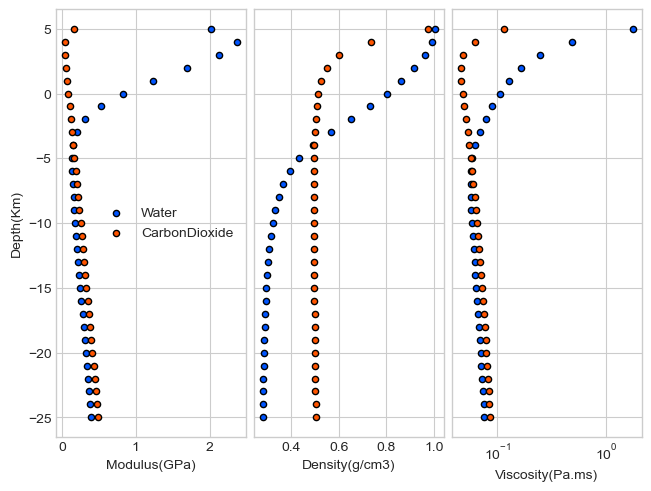

In [221]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(1, 3,constrained_layout = True)

fluid_names = {'Water':  '#0055FF', 'CarbonDioxide':'#FF5500'}
labels = {'Modulus(GPa)':'modulus', 'Density(g/cm3)':'density', 'Viscosity(Pa.ms)': 'viscosity'}

for lab, prop in enumerate(labels):
    for fluid in fluid_names:
        axs[lab].scatter(getattr(fluids(fluid),labels[prop]), -fluids(fluid).depth, c=fluid_names[fluid], s=20, edgecolors='black', label=fluid)
        axs[lab].set_xlabel(prop)

axs[0].legend()
axs[0].set_ylabel('Depth(Km)')

axs[1].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

axs[2].set_xscale('log')
axs[2].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)


In [341]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(volcanic_data.data[volcanic_data.data['z'] ==12], x='x', y='y',
              color='Qp')
fig.add_shape(type="rect",
    x0=xmin, y0=ymin, x1=xmax, y1=ymax,
    line=dict(color="White"),
    fillcolor="White",
    opacity=0.7,
)
fig.update_yaxes(
      scaleanchor="x",
      scaleratio=1,
)

fig.show()

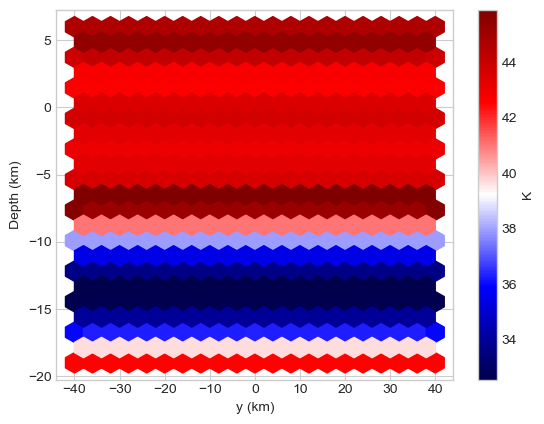

<Figure size 4212x4212 with 0 Axes>

In [281]:
volcanic_data.hexplot(plot="K", direction='x', value=1., grid=20)

<AxesSubplot:xlabel='z'>

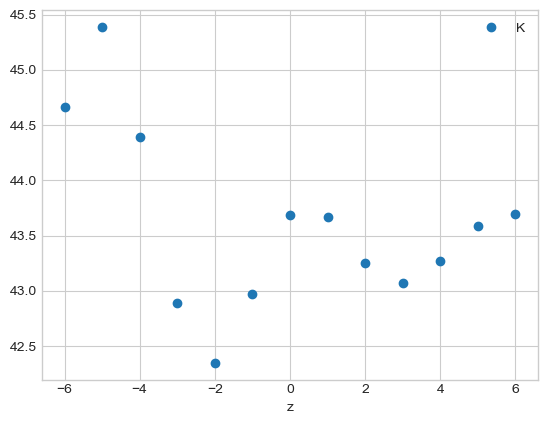

In [290]:
volcanic_data.data\
    [
    volcanic_data.data["z"].between(-6,6) &\
    volcanic_data.data["x"].between(xmin, xmax) &\
    volcanic_data.data["y"].between(ymin, ymax)
    ]\
    .groupby('z')\
    .mean()\
    .plot(y='K', style='o')

In [293]:
def avg_values(depth: int) -> dict:
    dict = {}
    temp_data = (volcanic_data.data['z'] == depth)
    Qp = volcanic_data.data[temp_data & (volcanic_data.data['Qp'].notna())]["Qp"].min()
    Qs = volcanic_data.data[temp_data & volcanic_data.data['Qs'].notna()]["Qs"].min()
    K = volcanic_data.data[temp_data & volcanic_data.data['K'].notna()]["K"].mean()
    mu = volcanic_data.data[temp_data & volcanic_data.data['μ'].notna()]["μ"].mean()
    dict['Qp'] = Qp
    dict['Qs'] = Qs
    dict['K'] = K
    dict['mu'] = mu
    return dict
avg_values(1)
   

{'Qp': 42.93, 'Qs': 40.93, 'K': 43.67, 'mu': 26.5}

In [242]:
volcanic_data.data['K/mu'] = volcanic_data.data['K']/volcanic_data.data['μ']

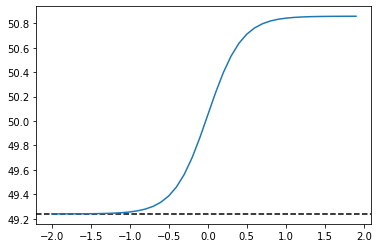

In [68]:
model1 = vq.RockPhysicsModel(dry_modulus=20.,shear_modulus=20, mineral_modulus=38, porosity=0.2, density=2.65)
model1.plot(fluid_modulus=2.5, epsilon=.03, tau=1)

In [66]:
highQpdata = data.data[data.data.Qp.notnull()][data.data.Qp>800]
highQsdata = data.data[data.data.Qp.notnull()][data.data.Qs>1000]
mod = highQpdata.K
she = highQsdata.μ
mod.mean(), she.mean()

<ipython-input-66-49cd03391929>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  highQpdata = data.data[data.data.Qp.notnull()][data.data.Qp>800]
<ipython-input-66-49cd03391929>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  highQsdata = data.data[data.data.Qp.notnull()][data.data.Qs>1000]


(43.68873573573574, 26.02604200853298)